# RoBERTa implementation

### Necessary files: all_data.csv, dataset.py

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import re
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import dataset

In [37]:
# Import full dataset
df = pd.read_csv('all_data.csv')

In [38]:
# Preprocessing the text 
def clean_text(text):
    ''' Removes punctuation and special characters, lowercases text'''
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    # Do not remove stop words to leave more context for Roberta
    return text

In [40]:
df['comment_text'] = df['comment_text'].fillna('') # Remove NaN values
df['cleaned_comment'] = df['comment_text'].apply(clean_text) 

df['target'] = df['toxicity'] # Mark target col
data = dataset.split_dataframe(df) # Apply common split 

# Assign dfs
traindf = data[0]
testdf = data[1]

# Downsizing dataset for reasonable runtimes with our resources 
trainsubset = traindf[:25000]
testsubset = testdf[:2500]

29992 159782


In [52]:
trainsubset.to_csv('trainsubset.csv')
testsubset.to_csv('testsubset.csv')


In [41]:
# Intialize roberta
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)  # labels=1 for regression task

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Tokenize with Roberta

Xtrain = list(trainsubset['cleaned_comment'])
ytrain = list(trainsubset['toxicity'])
Xtest = list(testsubset['cleaned_comment'])
ytest = list(testsubset['toxicity'])

# Tokenize data, add padding and truncation to match sizing, set maximum length of tokens per comment
Xtrain_encodings = tokenizer(Xtrain, truncation=True, padding=True, max_length=200, return_tensors='pt') 
Xtest_encodings = tokenizer(Xtest, truncation=True, padding=True, max_length=200, return_tensors='pt')


In [43]:
# Convert to tensors to prepare for dataloader 
ytrain_tensor = torch.tensor(ytrain, dtype=torch.float)
ytest_tensor = torch.tensor(ytest, dtype=torch.float)

Xtraintorch = torch.utils.data.TensorDataset(Xtrain_encodings['input_ids'], Xtrain_encodings['attention_mask'], ytrain_tensor)
Xtesttorch = torch.utils.data.TensorDataset(Xtest_encodings['input_ids'], Xtest_encodings['attention_mask'], ytest_tensor)


In [44]:
# Dataloaders
train_dataloader = DataLoader(Xtraintorch, batch_size=128, shuffle=True)
test_dataloader = DataLoader(Xtesttorch, batch_size=128, shuffle=True)
# test different batch sizes to reduce running time


##### Note: tried with batch size 8, 1000 rows of training data, 1 epoch: 10 min running time to train w Roberta

In [45]:
# Move to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta = roberta.to(device)

In [46]:
optimizer = torch.optim.AdamW(roberta.parameters(), lr=0.001) 
roberta.train()

for epoch in range(5):  
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()  # Clear previous gradients
        
        # Assign input data and labels from batch
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        # Forward pass: Compute predictions and loss
        outputs = roberta(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()  # backpropagate loss
        optimizer.step() 
        
    print(f"Epoch {epoch + 1}: Loss {loss.item()}")

100%|██████████| 196/196 [02:43<00:00,  1.20it/s]


Epoch 1: Loss 0.13646246492862701


100%|██████████| 196/196 [02:45<00:00,  1.18it/s]


Epoch 2: Loss 0.11496267467737198


100%|██████████| 196/196 [02:45<00:00,  1.19it/s]


Epoch 3: Loss 0.10320953279733658


100%|██████████| 196/196 [02:45<00:00,  1.18it/s]


Epoch 4: Loss 0.09113254398107529


100%|██████████| 196/196 [02:45<00:00,  1.18it/s]


Epoch 5: Loss 0.10897951573133469


In [47]:
def evaluate_model(model, test_dataloader):
    ''' Evaluate model on test data using same framework as the training loop
    Params: model: torch.nn.Module, test_dataloader: torch.dataloader 
    Output: tuple: pred (list) of predicted toxicity scores for the test data, actual (list) of true scores
    '''
    model.eval()
    pred = []
    actual = []
    
    with torch.no_grad(): # for faster running 
        for batch in tqdm(test_dataloader):
            # Get the input data and labels from the batch
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            # Forward pass: Compute predictions
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            pred.extend(logits.cpu().numpy())
            actual.extend(labels.cpu().numpy()) 

    return pred, actual
            
        

In [48]:
pred1, actual1 = evaluate_model(roberta, test_dataloader)

# Calculate MSE of roberta model, trained with batch size 128, 2500 rows of test data, 1 epoch
mse1 = mean_squared_error(actual1, pred1)

100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


In [49]:
print(f'Mean Squared Error for Roberta model using 25000/2500 data split: {mse1}')

Mean Squared Error for Roberta model using 25000/2500 data split: 0.20515302072255853


 #### Low MSE and Loss on Roberta toxicity predictions.

### Calculating disparate bias for comments that include identities:

In [50]:
# Add identity markers to df
identities = ['male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability']

# Treat NaN values in identity cols

trainsubset[identities] = trainsubset[identities].fillna(0.0)
testsubset[identities] = testsubset[identities].fillna(0.0)

/tmp/ipykernel_3103681/2622073997.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainsubset[identities] = trainsubset[identities].fillna(0.0)
/tmp/ipykernel_3103681/2622073997.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testsubset[identities] = testsubset[identities].fillna(0.0)


In [51]:
# Save previous Roberta predictions to test for bias
pred_bias = testsubset.copy()
pred_bias['predicted_toxicity'] = pred1 # append roberta's predictions to df 

pred_bias.to_csv('RoBERTa_predictions.csv', index=False)


In [17]:
def count_bias(df, identities):
    '''Find disparate bias/difference between the avg toxicity scores between comments containing 
    identities and comments not containing identities.  '''
    scores = {}
    for id in identities:
        identities_and_toxicity = df[df[id] == 1]['predicted_toxicity']
        no_identities_and_toxicity = df[df[id] == 0]['predicted_toxicity']

        avg_with_id = identities_and_toxicity.mean()
        avg_no_id = no_identities_and_toxicity.mean()
        
        disparity = avg_with_id - avg_no_id 
        
        scores[id] = disparity

    return scores

In [18]:
detected_bias = count_bias(pred_bias, identities)
print("Bias Scores (Disparate Impact) per Identity:")
for identity, score in detected_bias.items():
    print(f"{identity}: {score}")
    

Bias Scores (Disparate Impact) per Identity:
male: [0.02802683]
female: [-0.01844062]
transgender: [-0.60224073]
other_gender: [nan]
heterosexual: [0.04344688]
homosexual_gay_or_lesbian: [0.01882699]
bisexual: [nan]
other_sexual_orientation: [nan]
christian: [-0.09505423]
jewish: [-0.09174468]
muslim: [0.08145554]
hindu: [nan]
buddhist: [nan]
atheist: [-0.32830092]
other_religion: [nan]
black: [0.03684885]
white: [-0.01509563]
asian: [-0.01846347]
latino: [0.14318106]
other_race_or_ethnicity: [nan]
physical_disability: [nan]
intellectual_or_learning_disability: [nan]
psychiatric_or_mental_illness: [0.08566711]
other_disability: [nan]


<Figure size 1200x800 with 0 Axes>

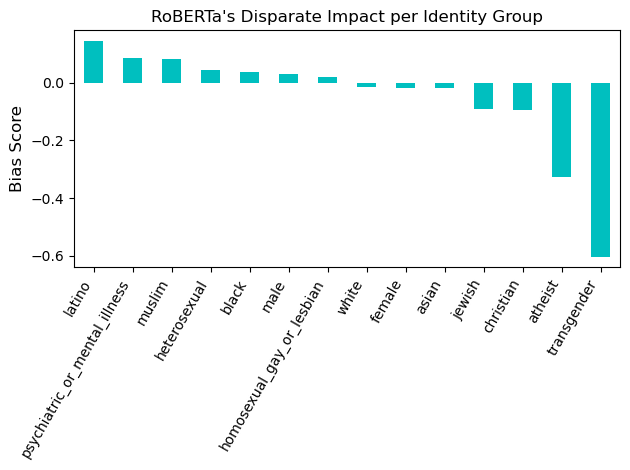

In [19]:
#Plot disparate bias found with Roberta model predictions 

biasdf = pd.DataFrame.from_dict(detected_bias, orient='index', columns=['bias'])
biasdf = biasdf.dropna()

plt.figure(figsize=(12, 8))
biasdf.sort_values('bias', ascending=False).plot(kind='bar', legend=False, color='c')
plt.title("RoBERTa's Disparate Impact per Identity Group", fontsize=12)
plt.ylabel('Bias Score', fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


### Adjusting model to address bias 

Using an adversarial loss function and calculating correlation both were unsucessful in avoiding the OutofMemory issue.

In [ ]:

def biasloss(predictions, labels, identities, bias_penalty_factor=0.5):
    '''Calculates loss based on model's toxicity prediction with the bias penalty, found with mean
    absolute difference between predictions and  
     bias_penalty_factor: factor for how much to penalize bias'''
    
    loss = f.mse_loss(predictions.flatten(), labels)
    mad = torch.mean(torch.abs(predictions.flatten() - identities.flatten()))

    # Calculate with  penalty
    total_loss = loss + mad
    
    return total_loss

In [26]:
# Train Roberta with bias penalty

def train_with_penalty(model, train_dataloader, optimizer, device, bias_penalty_factor=0.5):
    ''' Training roberta model with bias penalty'''
    
    model.train()
    
    for epoch in range(5):
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()  # Clear gradients

            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            identities_col = batch[3].to(device) 
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            pred = outputs.logits
            # Compute the loss with bias regularization
            loss = biasloss(pred, labels, identities_col, bias_penalty_factor)
            loss.backward() 
            optimizer.step()

    print(f"Epoch {epoch + 1}: Loss {loss.item()}")

### Apply bias mitigation to model

In [27]:
Xtrainb = list(trainsubset['cleaned_comment'])
ytrainb = list(trainsubset['toxicity'])
Xtestb = list(testsubset['cleaned_comment'])
ytestb = list(testsubset['toxicity'])

# Reinitialize tokenizer and roberta model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta2 = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)  

Xtrain_encodings = tokenizer(Xtrainb, truncation=True, padding=True, max_length=200, return_tensors='pt') # choosing max length of comment
Xtest_encodings = tokenizer(Xtestb, truncation=True, padding=True, max_length=200, return_tensors='pt')

# Convert to tensors to prepare for dataloader 
ytrain_tensor = torch.tensor(ytrainb, dtype=torch.float)
ytest_tensor = torch.tensor(ytestb, dtype=torch.float)

# Including identities to calculate bias 
identities_col_train = torch.tensor(trainsubset[identities].values, dtype=torch.float)
identities_col_test = torch.tensor(testsubset[identities].values, dtype=torch.float)
Xtraintorch = TensorDataset(Xtrain_encodings['input_ids'], Xtrain_encodings['attention_mask'], ytrain_tensor, identities_col_train)
Xtesttorch = TensorDataset(Xtest_encodings['input_ids'], Xtest_encodings['attention_mask'], ytest_tensor, identities_col_test)
# Try different batch size to reduce running time
train_dataloader = DataLoader(Xtraintorch, batch_size=128, shuffle=True)
test_dataloader = DataLoader(Xtesttorch, batch_size=128, shuffle=False)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# move to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta2 = roberta2.to(device)
optimizer = torch.optim.AdamW(roberta2.parameters(), lr=1e-5)

In [ ]:
# Empty cache to avoid memory shortages 
with torch.no_grad():
    torch.cuda.empty_cache()

In [30]:
train_with_penalty(roberta2, train_dataloader, optimizer, device, bias_penalty_factor=0.5)


  0%|          | 0/196 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 300.00 MiB. GPU 0 has a total capacity of 23.69 GiB of which 187.00 MiB is free. Process 970332 has 1.66 GiB memory in use. Including non-PyTorch memory, this process has 21.81 GiB memory in use. Of the allocated memory 21.20 GiB is allocated by PyTorch, and 310.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Unsurpassable out of memory error. Attempting to run the second training on a separate notebook to avoid memory issues did not fix the issue. 

In [ ]:
# Evaluation with bias
pred2, actual2 = evaluate_model(roberta2, test_dataloader)
mse2 = mean_squared_error(actual2, pred2)

print(f'Mean Squared Error for Roberta bias mitigated model using 25000/2500 data split: {mse2}')

In [ ]:
# Compare results